# Study of the Swiss electrical mix (and imports) between 2016 and 2021

This notebook is a study of the Swiss electrical mix (production and imports) between 2016 and 2021. It aims to represent the repartition of the consumed electricity and the associated ghg emissions.
It illustrates some possible uses of EcoDynElec.

We perform a historical analysis of the Swiss energy mix over 5 years, between 2016 and 2021. We have hourly European electricity production and exchange data, from which we calculate the Swiss electricity mix and its carbon impact (in grams of CO2 per kWh).
We mainly use two information types:
- The **producer mix** refers to the electricity produced in the designated country. It contains only local sources. When converting the producer mix into kWh, we obtain the **electricity production** of the country.
- The **consumer mix** refers to the electricity consumed in the designated country. It contains local sources as well as the import of electricity from other countries. When converting the consumer mix into kWh, we obtain the **electricity consumption** of the country.

These data make it possible to calculate the **carbon impact hour by hour** of the electricity produced and consumed in the country (these two impacts are therefore different), and then to study the sources of these emissions.

## 0. Configuring EcoDynElec and loading the data

In [1]:
# Autoreload imports
%load_ext autoreload
%autoreload 2

# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ecodynelec.parameter import Parameter  # Import the class to manipulate parameters
from examples.mix_analysis.analysis_functions import format_data_0, get_metrics, plot_hourly_heatmap, plot_years

In [25]:
# EcoDynElec configuration
my_config = Parameter()
my_config.freq = "H"
my_config.ctry = ['AT', 'CH', 'DE', 'FR', 'IT']
my_config.target = ['CH']  # You can put multiple targets here
# Enable this if you want to plot fig 6 (will impact the computation time - it took me 15min)
#my_config.target = ['CH', 'AT', 'FR', 'DE']
my_config.data_cleaning = True
my_config.path.generation = "./mix_analysis/downloads/generations/"
my_config.path.exchanges = "./mix_analysis/downloads/exchanges/"
my_config.path.generation = "../etude_stat/test_data/downloads/generations/"
my_config.path.exchanges = "../etude_stat/test_data/downloads/exchanges/"
my_config.residual_global = False
# Use the local residual to compute the CH mix (see the documentation for more details)
my_config.residual_local = True

# Years to study
years = ['2016', '2017', '2018', '2019', '2020', '2021']

#### 0.1 Download and generate data files
This can done once, then the electrical mix and impact files will be saved and can be loaded directly (see 0.2)

In [26]:
# Data downloading configuration
my_config.server.useServer = False
my_config.server.username = 'your entsoe username'
my_config.server.password = 'your entsoe password'

In [27]:
from examples.mix_analysis.analysis_functions import generate_data

# Allows to run this notebook from another notebook without generating the data again (using %run)
if 'skip_generation' not in globals():
    raws, mixs, impacts = generate_data(my_config, years)
else:
    print("Skipping data generation")

#### 0.2 Load data from saved files
If the files for the years of interest have already been generated, they can be loaded directly in this section

In [14]:
from examples.mix_analysis.analysis_functions import load_data

raws, mixs, impacts = load_data(my_config, years, savedir="../examples/mix_analysis/results/")

### 0.3 Pre-processing the data
Here we reformat the data to make it easier to manipulate and plot

In [32]:
# NOTE: Unless you use multiple targets (see section 0.), these dicts will contain only one element, corresponding to the target country

# Dict of dicts containing for each target country:
# 'raw_df': Productions in MWh for each power source in each country, contributing to the target
# 'df': Total consumption in the target country (column 'sum') and contribution of each country (MWh)
raw_productions = {}
# Dict of dicts containing for each target country:
# 'raw_df': Shares of each power source in the total mix of the target country (0-1)
# 'df': Shares of each country in the total mix of the target country (0-1)
electricity_mixs = {}
# Dict of dicts containing for each target country:
# 'raw_df': Share of ghg emissions of each power source (gCO2eq from this source for one kWh consumed in the target country). This is **not** the ghg emissions for one kWh produced by this source.
# 'df': Ghg emissions in gCO2eq/kWh of the target country consumption mix (column 'sum') and contribution of each country in this mix (gCO2eq for one kWh consumed in the target country)
electricity_impacts = {}
# Dict of dataframes containing for each country the ghg emissions of one kWh produced in that country (gCO2eq/kWh) (it's the impact of the producing mix of each country)
producing_electricity_impacts = {}

# Multi-target: correctly extract the data for each target country
if len(my_config.target) > 1:
    for c in my_config.target:
        raw_productions[c] = format_data_0({y: raws[y][c] for y in years})
        electricity_mixs[c] = format_data_0({y: mixs[y][c] for y in years})
        electricity_impact = format_data_0({y: impacts[y][c] for y in years})
        producing_electricity_impact = electricity_impact['df'][c] / electricity_mixs[c]['df'][c]
        # convert kgCO2eq/kWh -> gCO2eq/kWh
        electricity_impacts[c] = {k: v * 1000 for k, v in electricity_impact.items()}
        producing_electricity_impacts[c] = producing_electricity_impact * 1000

    # Extract the data for CH
    raw_production = raw_productions['CH']
    electricity_mix = electricity_mixs['CH']
    electricity_impact = electricity_impacts['CH']
    producing_electricity_impact = pd.DataFrame(producing_electricity_impacts)
else: # Easy case: only one target country (not that figure 6 and table 4 will not be available)
    raw_production = format_data_0({y: raws[y] for y in years})
    electricity_mix = format_data_0({y: mixs[y] for y in years})
    electricity_impact = format_data_0({y: impacts[y] for y in years})
    producing_electricity_impact = electricity_impact['df'] / electricity_mix['df']
    # convert kgCO2eq/kWh -> gCO2eq/kWh
    electricity_impact = {k: v * 1000 for k, v in electricity_impact.items()}
    producing_electricity_impact = producing_electricity_impact * 1000

### 0.4 Plots configuration

Some color codes for each country

In [33]:
ordered_countries = ['CH', 'DE', 'FR', 'AT', 'IT', 'Other']
colormap = {
    'sum': 'lightgray',
    'CH': '#1f77b4',
    'DE': '#c62728',
    'FR': '#2ca02c',
    'IT': '#9467bd',
    'AT': '#ff7f0e',
    'Other': '#e377c2'
}
colormap_extended = colormap | {
    'Nuclear_CH': '#8c564b',
    'Residual_Hydro_Run-of-river_and_poundage_CH': '#000080',  # Couleur bleu marine
    'Residual_Hydro_Water_Reservoir_CH': '#004090',  # Couleur bleu marine
    'Hydro_Water_Reservoir_CH': '#98df8a',
    'Residual_Other_CH': '#ffbb78',
    'Hydro_Pumped_Storage_CH': '#bcbd22',
    'Hydro_Run-of-river_and_poundage_CH': '#17becf',
    'Other_CH': '#1f77b4'
}
ordered_colors = [colormap[c] for c in ordered_countries]

## 1. Inter-annual analysis

Swiss annual electricity consumption

In [34]:
yearly_prod = raw_production['raw_df'].resample('Y').sum().sum(axis=1).map(lambda x: f'{x / 1000:.2f} GWh')
yearly_prod.index = pd.Series(years)
print(yearly_prod)

2016    63463.61 GWh
2017    64816.20 GWh
2018    65928.32 GWh
2019    66036.88 GWh
2020    63419.46 GWh
2021    65138.18 GWh
dtype: object


Monthly electricity consumption in 2021

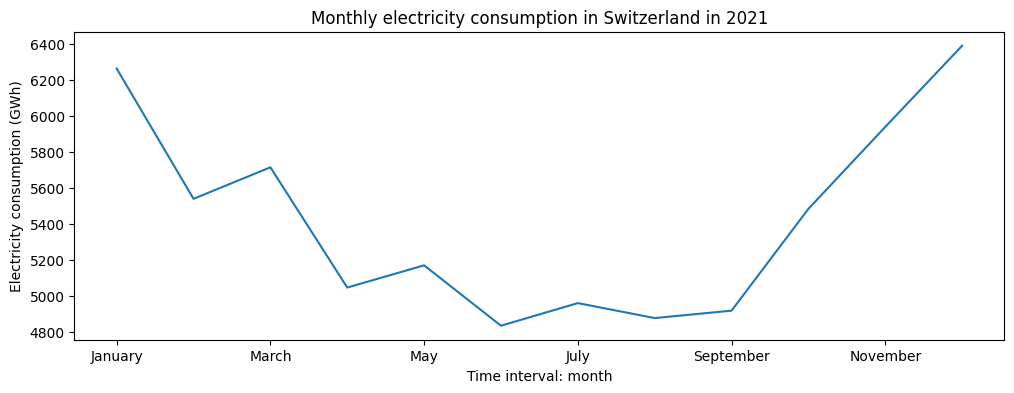

In [35]:
monthly_prod = raw_production['raw_df']
monthly_prod = monthly_prod.loc[[d.year == 2021 for d in monthly_prod.index]]
monthly_prod = monthly_prod.resample('M').sum().sum(axis=1).map(
    lambda x: x / 1000)  #.map(lambda x: f'{x / 1000:.2f} GWh')
monthly_prod.index = [f'{d.month_name()}' for d in monthly_prod.index]
#print(monthly_prod)
monthly_prod.plot(figsize=(12, 4), title='Monthly electricity consumption in Switzerland in 2021')
plt.xlabel('Time interval: month')
plt.ylabel('Electricity consumption (GWh)');

2021 Monthly production from selected sources (helps to validate the data)

In [19]:
cols = [
    'Solar_CH']  # ['Residual_Hydro_Water_Reservoir_CH', 'Residual_Hydro_Run-of-river_and_poundage_CH', 'Residual_Other_CH'] ...
start = '2021-01-01'
end = '2021-12-31'
monthly_prod = raw_production['raw_df'][cols][start:end].resample('M').mean()
monthly_prod

,Solar_CH
2021-01-31,33.653084
2021-02-28,88.293861
2021-03-31,195.414352
2021-04-30,326.001862
2021-05-31,316.525360
2021-06-30,405.865631
2021-07-31,346.889801
2021-08-31,298.491943
2021-09-30,216.132111
2021-10-31,111.263557


Main power sources in the Swiss electricity mix

In [20]:
yearly_mix = electricity_mix['raw_df'].resample('Y').mean()
local_cols = yearly_mix.mean().nlargest(20).index.tolist()
yearly_mix = yearly_mix.applymap(lambda x: f'{x * 100:.0f} %')
yearly_mix.index = pd.Series(years)
print(yearly_mix[local_cols])

     Nuclear_CH Residual_Hydro_Run-of-river_and_poundage_CH   
2016       21 %                                        18 %  \
2017       22 %                                        16 %   
2018       26 %                                        15 %   
2019       27 %                                        15 %   
2020       26 %                                        16 %   
2021       21 %                                        16 %   

     Hydro_Water_Reservoir_CH Hydro_Pumped_Storage_CH Residual_Other_CH   
2016                      8 %                     5 %               7 %  \
2017                      9 %                     7 %               6 %   
2018                     11 %                     7 %               6 %   
2019                     12 %                     8 %               6 %   
2020                     12 %                     7 %               5 %   
2021                     12 %                     7 %               4 %   

     Nuclear_FR Residual_Hydro_W

Consumed electricity by country of origin and associated GHG emissions

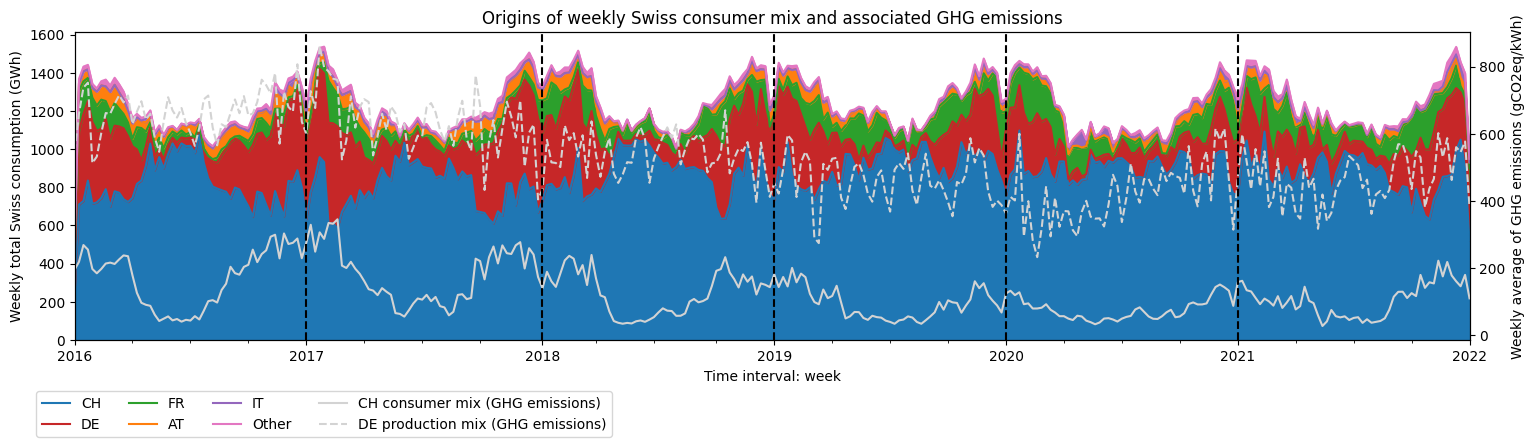

In [36]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 4))
ax1.set_title("Origins of weekly Swiss consumer mix and associated GHG emissions")
mix_import = electricity_mix['df'].drop(['sum'], axis=1)
mix_import = mix_import.multiply(raw_production['df']['sum'], axis='index').resample('W').sum() / 1000
mix_import[ordered_countries].plot.area(ax=ax1, color=ordered_colors, legend=False)
ax1.set_xlabel('Time interval: week')
ax1.set_ylabel('Weekly total Swiss consumption (GWh)')

ax2 = ax1.twinx()
ch_consumer_impact = (electricity_impact['df']['sum']).resample('W').mean()  # convert kgCO2eq/kWh -> gCO2eq/kWh
ch_consumer_impact.plot(ax=ax2, linestyle='-', color=[colormap['sum']])
de_producing_impact = (producing_electricity_impact['DE']).resample('W').mean()  # convert kgCO2eq/kWh -> gCO2eq/kWh
de_producing_impact.plot(ax=ax2, linestyle='--', color=[colormap['sum']])
ax2.set_ylabel('Weekly average of GHG emissions (gCO2eq/kWh)')

plot_years()

fig.legend(np.concatenate([ax1.get_lines(), ax2.get_lines()]),
           np.concatenate([ax1.get_legend_handles_labels()[1],
                           ['CH consumer mix (GHG emissions)', 'DE production mix (GHG emissions)']]),
           loc='upper left', ncol=4, bbox_to_anchor=(0.1, 0));

Mix by source (import source and main CH production sources)

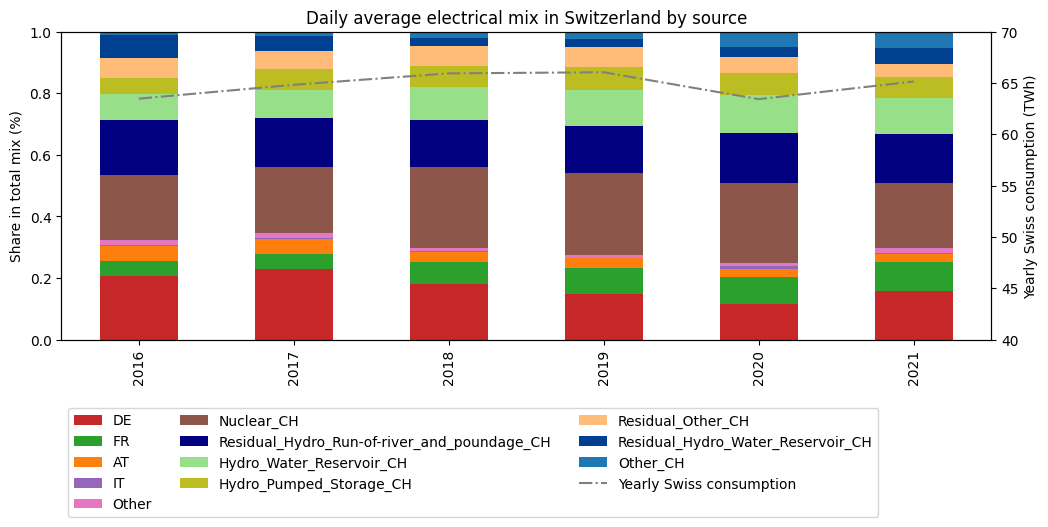

In [37]:
fig, ax = plt.subplots(figsize=(12, 4))

# import mix
compute_mix = electricity_mix['df'][ordered_countries].drop('CH', axis=1)
# local CH mix
local_mix = electricity_mix['raw_df']  # wtf .resample('W').mean()
local_mix = local_mix.drop(local_mix.loc[:, [not k.endswith('CH') or 'Mix' in k for k in local_mix.columns]], axis=1)
local_cols = local_mix.mean().nlargest(len(ordered_countries)).index.tolist()
local_mix['Other_CH'] = local_mix.drop(local_cols, axis=1).sum(axis=1)
# merged mix
compute_mix = pd.concat([compute_mix, local_mix[local_cols], local_mix['Other_CH']], axis=1)
metric = 'mean'
metric_values = get_metrics(years, compute_mix, [metric], 'Y')
colors = [colormap_extended[c] for c in compute_mix.columns]
# yearly consumption (TWh), used for comparison
yearly_consumption = raw_production['df']['sum'].resample('Y').sum() / 1e6
yearly_consumption.index = metric_values[metric].index  # keep same x axis
# plot
ax2 = ax.twinx()
ax = metric_values[metric].plot.bar(ax=ax, stacked=True, color=colors, legend=True)
yearly_consumption.plot(ax=ax2, linestyle='-.', color='gray', legend=False, label='Yearly Swiss consumption')
ax.set_title(f'Daily average electrical mix in Switzerland by source')
ax.set_label('date')
ax.set_ylabel('Share in total mix (%)')
ax.set_ylim(0, 1)
ax2.set_ylabel('Yearly Swiss consumption (TWh)')
ax2.set_ylim(40, 70)
# Merge legend of both axes
handles, labels = ax.get_legend_handles_labels()
handles.append(ax2.get_lines()[0])
labels.append(ax2.get_legend_handles_labels()[1][0])
ax.legend(handles, labels, ncol=3,
          loc='upper left', bbox_to_anchor=(0, -0.2))

Impact of consumption mix over five years

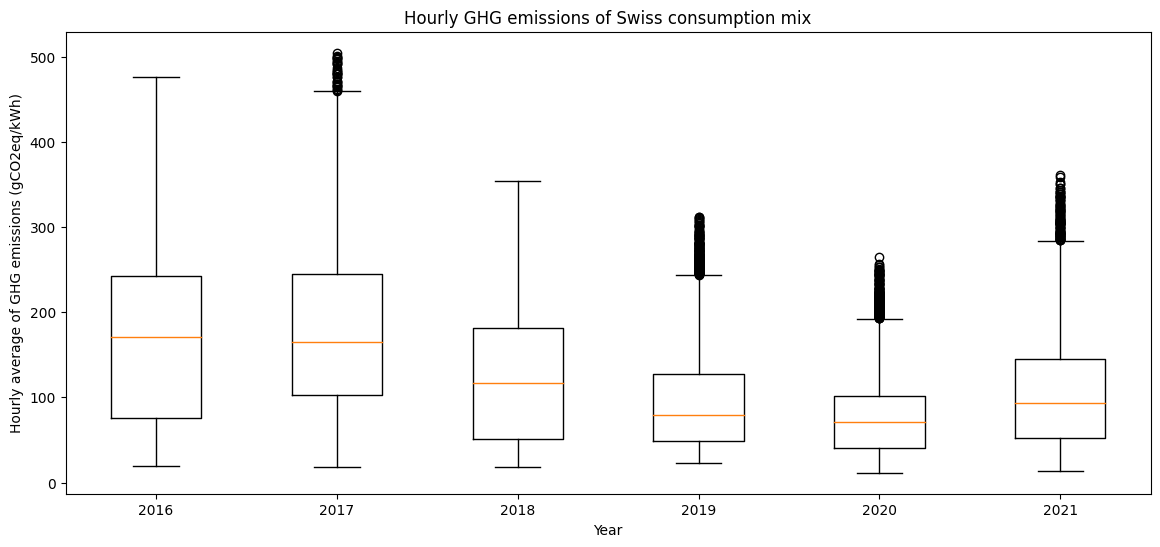

In [38]:
fig, ax = plt.subplots(figsize=(14, 6))
data = electricity_impact['df'].astype('float32')
data = pd.DataFrame(data['sum'])
data['Year'] = [date.year for date in data.index]
grouped_data = data.groupby('Year')
seasonal_data = [grouped_data.get_group(season)[data.columns[0]] for season in grouped_data.groups]
ax.boxplot(seasonal_data)
ax.set_xticklabels(grouped_data.groups.keys())
ax.set_title('Hourly GHG emissions of Swiss consumption mix')
ax.set_xlabel('Year')
ax.set_ylabel('Hourly average of GHG emissions (gCO2eq/kWh)');

Impact of production mix over five years

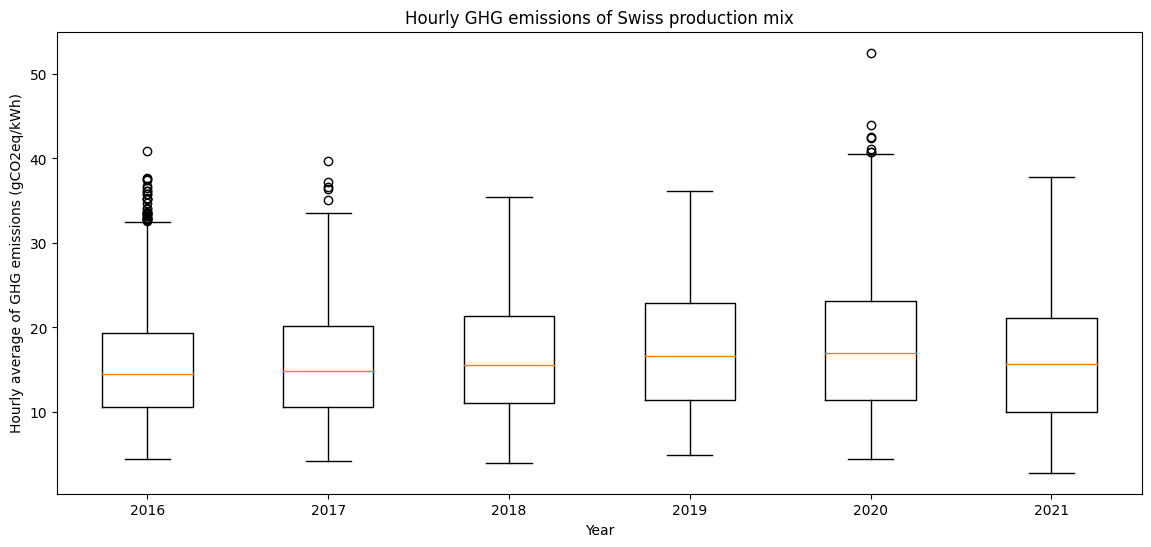

In [39]:
fig, ax = plt.subplots(figsize=(14, 6))
data = electricity_impact['raw_df'].astype('float32')
data = data.drop(data.loc[:, [not k.endswith('CH') or 'Mix' in k for k in data.columns]], axis=1)
data = pd.DataFrame(data.sum(axis=1))
data['Year'] = [date.year for date in data.index]
grouped_data = data.groupby('Year')
seasonal_data = [grouped_data.get_group(season)[data.columns[0]] for season in grouped_data.groups]
ax.boxplot(seasonal_data)
ax.set_xticklabels(grouped_data.groups.keys())
ax.set_title('Hourly GHG emissions of Swiss production mix')
ax.set_xlabel('Year')
ax.set_ylabel('Hourly average of GHG emissions (gCO2eq/kWh)');

Figure 6, comparison between the producing impacts of several countries and the import mix of Switzerland
**Make sure to compute the production mix of *all* the countries before running this cell (enable the corresponding line in section 0)**

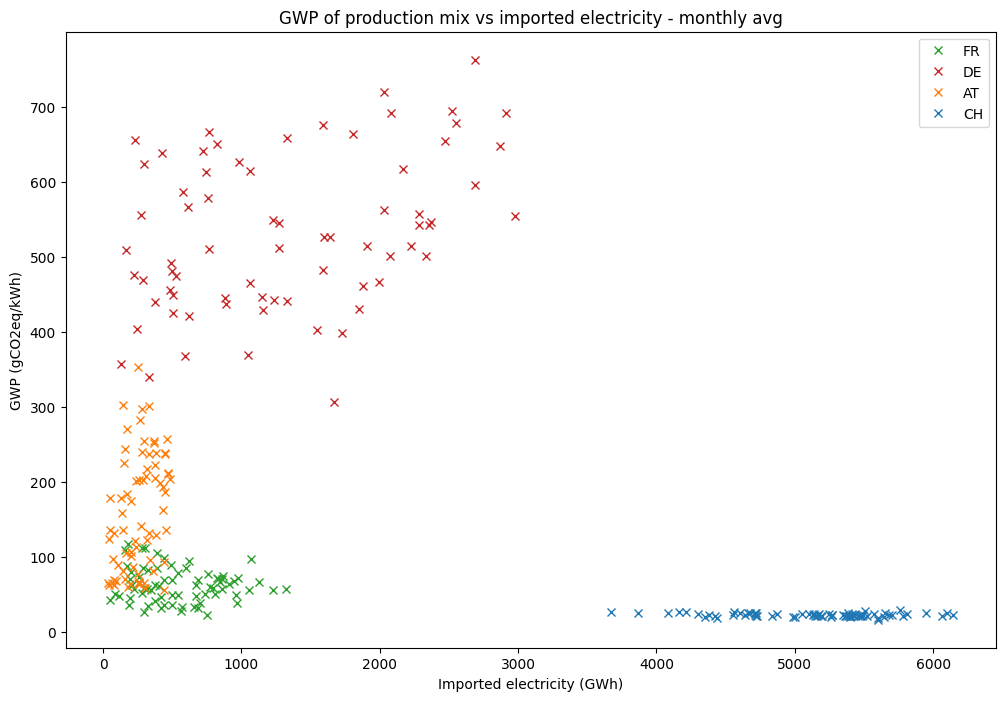

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.linspace(0, 1, 100)
countries = ['FR', 'DE', 'AT', 'CH']
for c in countries:
    #mx = electricity_mixs['CH']['df'][c].resample('M').mean()
    mx = raw_productions['CH']['df'][c].resample('M').mean()
    px = producing_electricity_impacts[c].resample('M').mean()
    plt.plot(mx, px, color=colormap[c], label=c, marker='x', linestyle='None')
plt.title('GWP of production mix vs imported electricity - monthly avg')
plt.xlabel('Imported electricity (GWh)')
plt.ylabel('GWP (gCO2eq/kWh)')
plt.legend();

Table 4, comparison between the producing impacts of several countries an the impacts of imports in Switzerland
**Make sure to compute the production mix of *all* the countries before running this cell (enable the corresponding line in section 0)**

In [47]:
countries = ['FR', 'DE', 'AT']
table = {}
for c in countries:
    table[c + '_prod'] = producing_electricity_impacts[c].resample('M').mean()
for c in countries:
    emitted_co2 = producing_electricity_impacts[c].multiply(raw_productions['CH']['df'][c])
    emitted_co2 = emitted_co2.resample('M').sum() / raw_productions['CH']['df'][c].resample('M').sum()
    table[c + '_import'] = emitted_co2
tabled = pd.DataFrame(table)
for c in countries:
    tabled[c + '_diff'] = (tabled[c + '_import'].astype(float) - tabled[c + '_prod'].astype(float)) / tabled[
        c + '_prod'].astype(float) * 100
tabled = tabled.applymap(lambda val: f'{val:.2f}').T
ordered_table = tabled.loc[
    ['AT_prod', 'AT_import', 'AT_diff', 'FR_prod', 'FR_import', 'FR_diff', 'DE_prod', 'DE_import', 'DE_diff']]
ordered_table.index = ['AT production mix impact', 'Impact of AT electricity consumed in CH', 'Difference (%)',
                       'FR production mix impact', 'Impact of FR electricity consumed in CH', 'Difference (%)',
                       'DE production mix impact', 'Impact of DE electricity consumed in CH', 'Difference (%)']

In [49]:
ordered_table

,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,...,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31
AT production mix impact,282.96,203.40,209.89,141.56,65.66,59.40,58.73,56.14,122.35,207.46,...,201.88,158.52,70.32,65.11,62.32,66.83,89.09,178.98,270.43,240.23
Impact of AT electricity consumed in CH,283.92,203.51,208.25,143.67,62.99,62.76,56.92,56.66,119.52,202.43,...,194.95,174.88,72.19,45.11,43.94,64.13,55.75,198.28,289.37,235.25
Difference (%),0.34,0.06,-0.79,1.49,-4.07,5.66,-3.08,0.93,-2.32,-2.42,...,-3.43,10.32,2.66,-30.71,-29.50,-4.03,-37.43,10.78,7.01,-2.07
FR production mix impact,68.17,59.28,69.48,49.45,35.23,35.67,43.03,48.01,87.52,98.28,...,66.74,61.15,31.28,36.36,36.25,27.96,50.94,55.41,94.33,84.72
Impact of FR electricity consumed in CH,65.04,56.96,70.27,50.95,31.77,28.73,28.75,38.74,79.35,98.58,...,63.66,54.83,26.52,30.78,29.25,24.72,44.38,48.96,85.98,69.48
Difference (%),-4.59,-3.91,1.13,3.04,-9.83,-19.47,-33.19,-19.31,-9.34,0.31,...,-4.61,-10.33,-15.21,-15.35,-19.32,-11.60,-12.88,-11.63,-8.85,-17.99
DE production mix impact,654.12,616.70,691.98,666.28,622.93,655.67,637.94,613.73,675.28,719.58,...,441.64,429.18,367.42,480.64,455.60,424.64,544.47,460.78,542.49,514.54
Impact of DE electricity consumed in CH,654.65,610.97,689.02,661.39,601.53,633.12,624.47,605.08,657.57,713.45,...,388.42,433.81,302.54,405.31,395.69,366.37,511.42,445.63,530.97,501.33
Difference (%),0.08,-0.93,-0.43,-0.73,-3.43,-3.44,-2.11,-1.41,-2.62,-0.85,...,-12.05,1.08,-17.66,-15.67,-13.15,-13.72,-6.07,-3.29,-2.12,-2.57


## 2. Intra-annual analysis

Heatmaps of :
- CH consumption
- CH production
- DE and FR imports
- Hydro production (pumped storage and water reservoir)

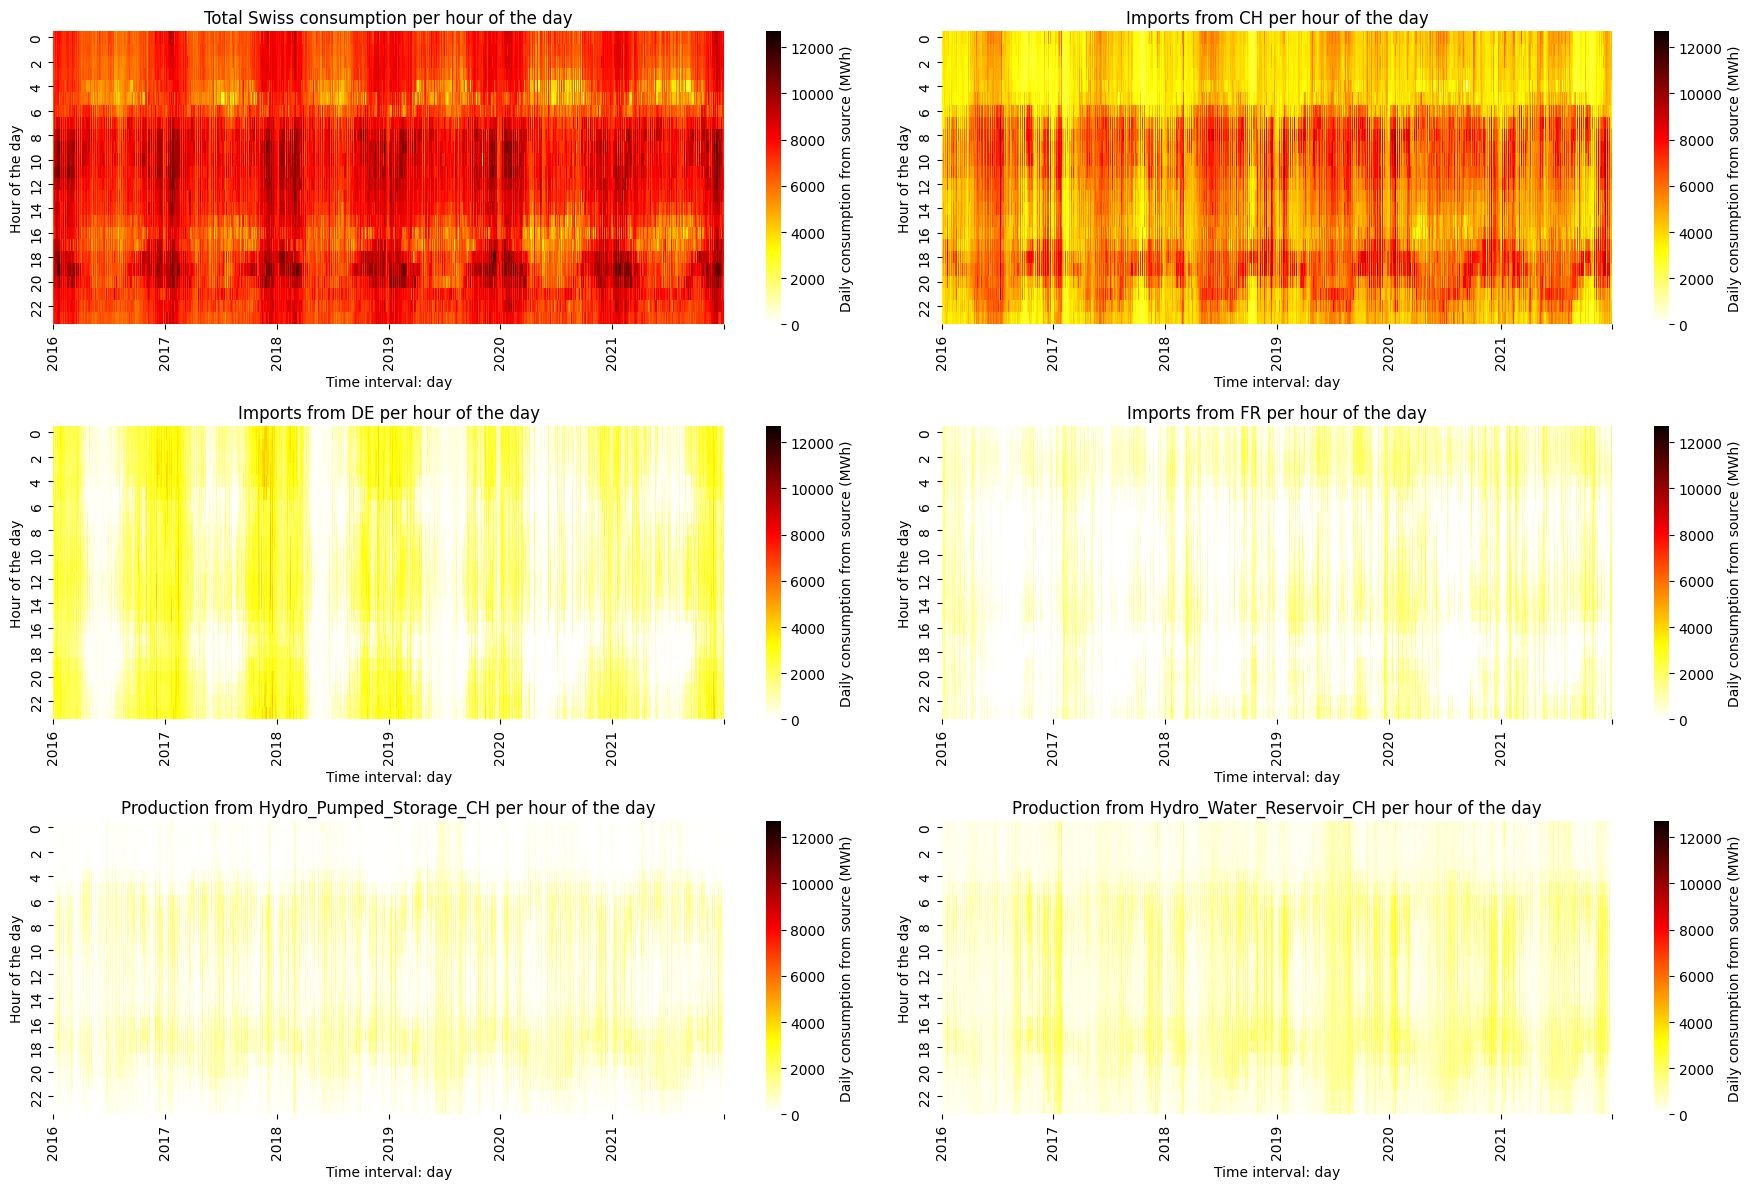

In [44]:
fig, ax = plt.subplots(3, 2, figsize=(18, 12))
countries = ['sum', 'CH', 'DE', 'FR']
# Heatmap import
data = raw_production['df'][countries].copy()
val_max = data[countries].max().max()
for i in range(len(countries)):
    series = data[countries[i]]
    xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)
    plot_hourly_heatmap(data, countries[i], xlabels, 'Imports from ' + countries[i],
                        'Daily consumption from source (MWh)', val_max=val_max, fig=fig, ax=ax[i // 2, i % 2])

ax[0, 0].set_title('Total Swiss consumption per hour of the day')

# Heatmap hydro
cols = ['Hydro_Pumped_Storage_CH', 'Hydro_Water_Reservoir_CH']
data2 = raw_production['raw_df'][cols]
for i in range(len(cols)):
    series = data2[cols[i]]
    xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)
    plot_hourly_heatmap(data2, cols[i], xlabels, 'Production from ' + cols[i], 'Daily consumption from source (MWh)',
                        val_max=val_max, fig=fig, ax=ax[2, i])

fig.tight_layout()

Heatmap of the carbon emissions associated to the Swiss consumption mix :

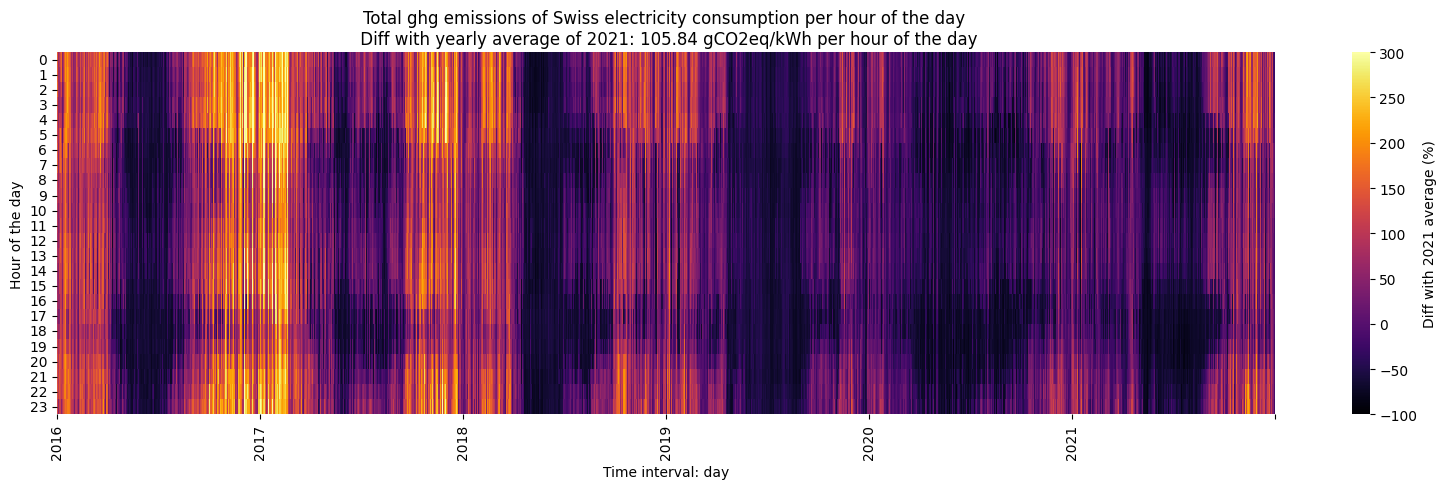

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
# Heatmap import
data = electricity_impact['df'][['sum']].copy()
val_mean = data['sum'].loc['2021-01-01':'2021-12-31'].mean()
data = (data - val_mean) / val_mean * 100
val_min = -100
val_max = 300
series = data['sum']
xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)
plot_hourly_heatmap(data, 'sum', xlabels,
                    'Total ghg emissions of Swiss electricity consumption per hour of the day \n Diff with yearly average of 2021: ' + str(
                        round(val_mean, 2)) + ' gCO2eq/kWh', 'Diff with 2021 average (%)', val_min=val_min,
                    val_max=val_max, fig=fig, ax=ax, cmap='inferno')

fig.tight_layout()